# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import *
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-17 22:31:33.534976: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 22:31:33.565225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-17 22:31:34.593350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:31:34.596946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:31:34.597069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 1000
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-17 22:31:34.606831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:31:34.606976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:31:34.607040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 32, 32, 3) => batch_size: 32, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-17 22:31:35.775395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


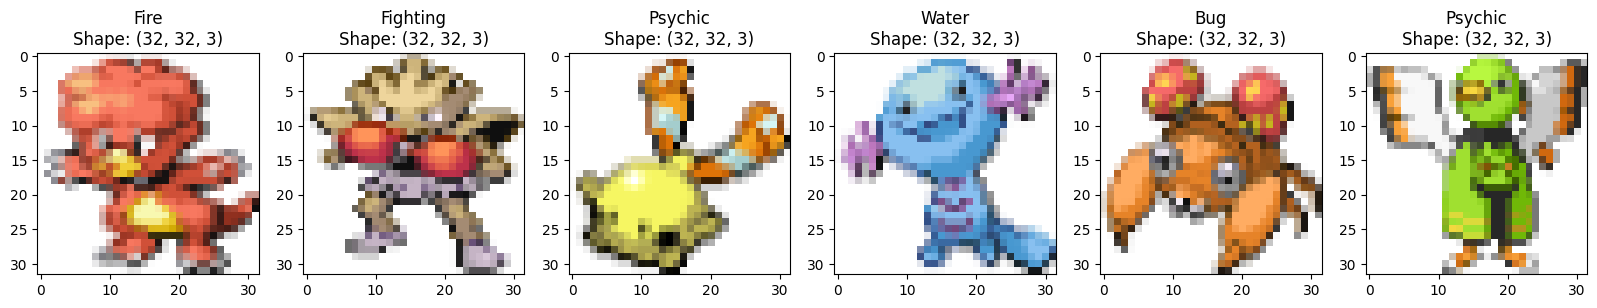

2024-04-17 22:31:36.298753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 32, 32, 3)
(32, 18)


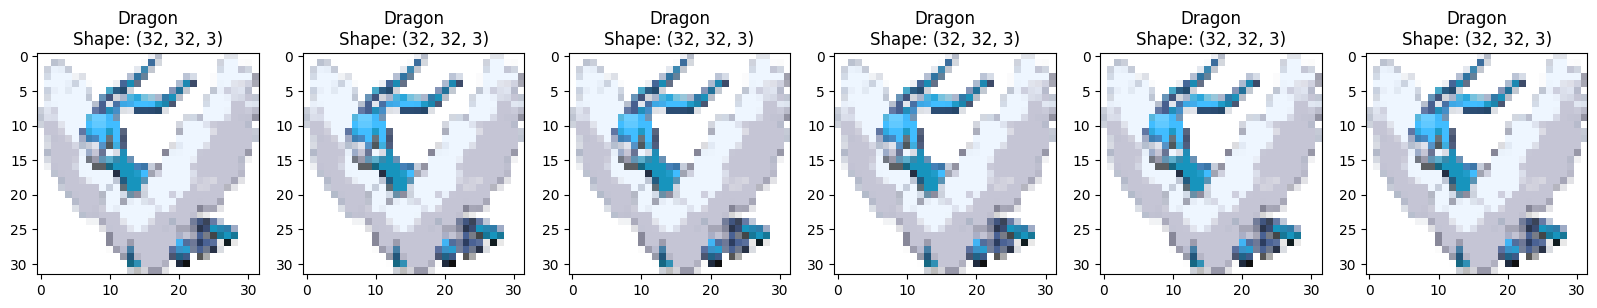

2024-04-17 22:31:36.745104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-17 22:31:36.746060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(256).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

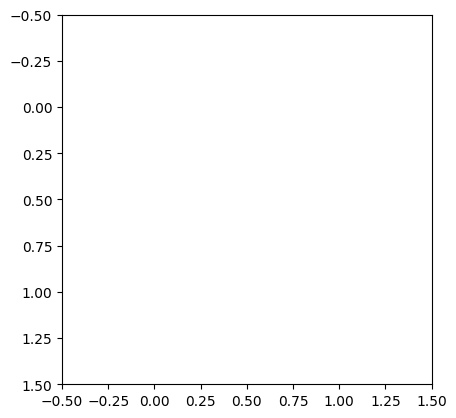

In [7]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
if IMG_SIZE == 64:
    x = 60
    y = 60
    w = 50
    h = 50
elif IMG_SIZE == 32:
    x = 30
    y = 30
    w = 25
    h = 25

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [8]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-17 22:31:37.895456: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-17 22:31:38.543589: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 22:31:38.678112: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 303.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 22:31:38.849282: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could 

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 1.3619
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.9202
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.8179
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.7396
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.7253
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.6747
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.5786
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.5274
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.3230
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.3108
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.2128
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.2935
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.3083
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1342
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.2088
Epoch 16/100
8/8

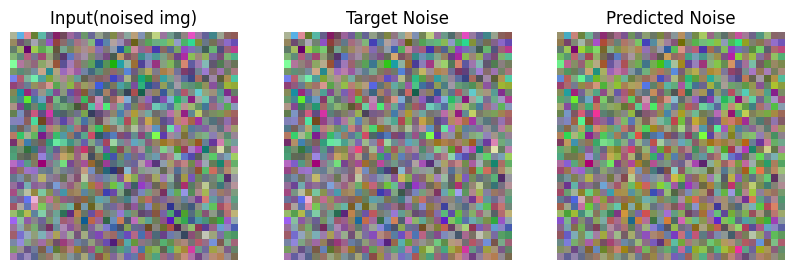

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00023528496, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7613154, shape=(), dtype=float32)


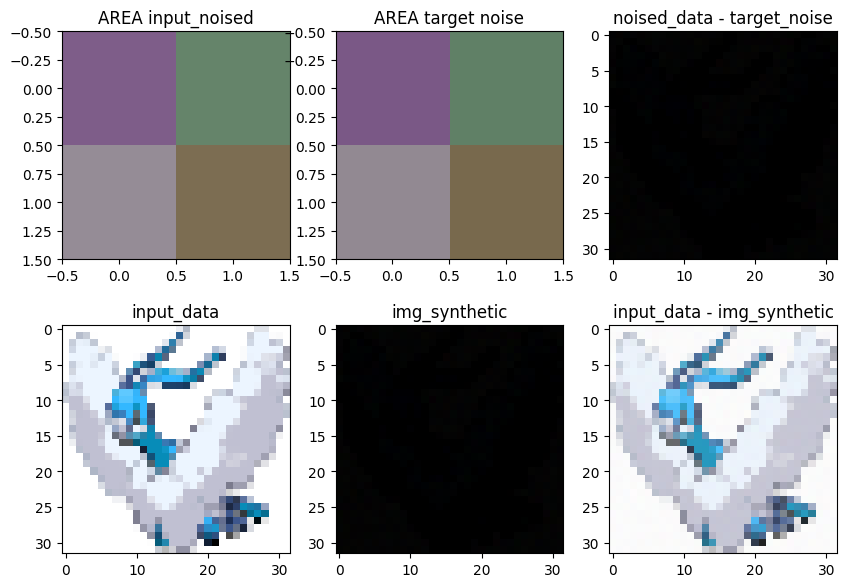

Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.29it/s]


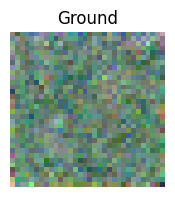

8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 0.1982  
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.3411
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.2000
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.3595
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.4555
Epoch 25/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.1347
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.1988
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0978
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.1164
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0939
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.1048
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0984
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1223
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.2349
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0985
Epoch 35

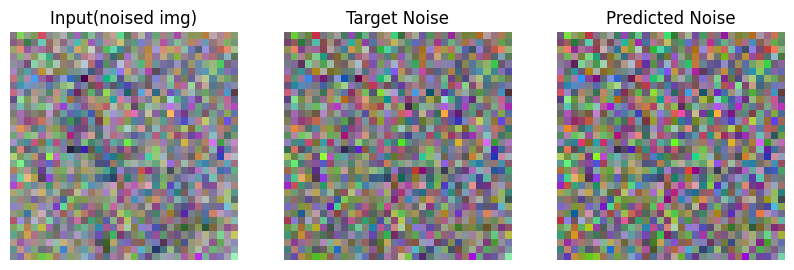

MSE area:  tf.Tensor(0.004767747, shape=(), dtype=float32)
MSE:  tf.Tensor(0.66893643, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


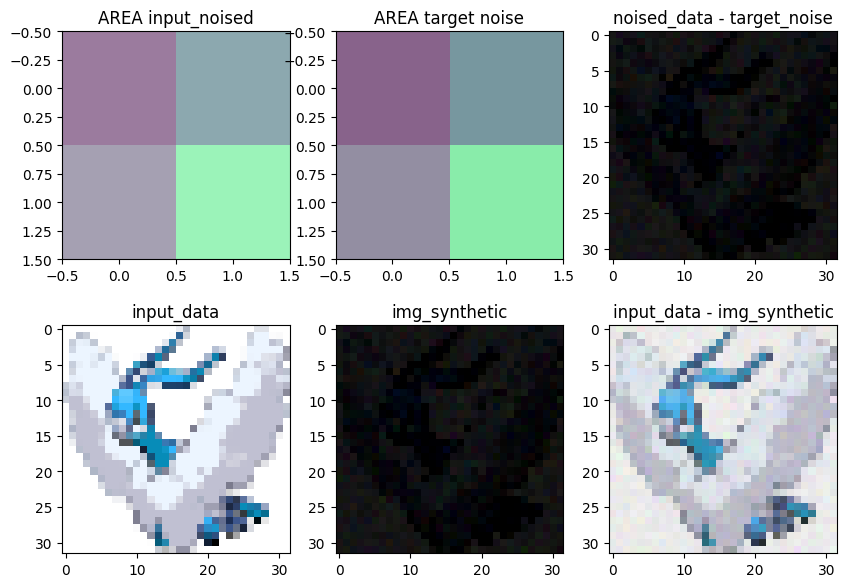

Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.76it/s]


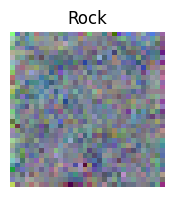

8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 0.0551  
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.1546
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.1268
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.2042
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.1385
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.1628
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0945
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.1126
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0754
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0687
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.1098
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.1068
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.2568
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.1245
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.1148
Epoch 55

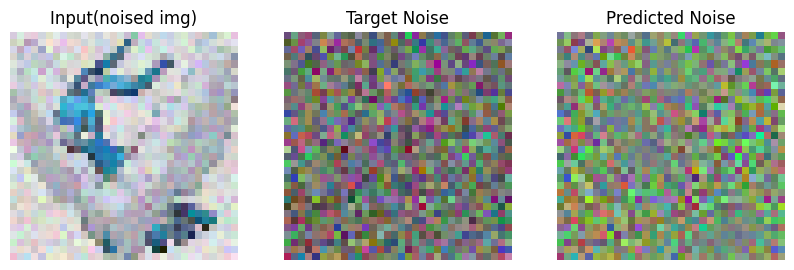

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.16325228, shape=(), dtype=float32)
MSE:  tf.Tensor(0.30928695, shape=(), dtype=float32)


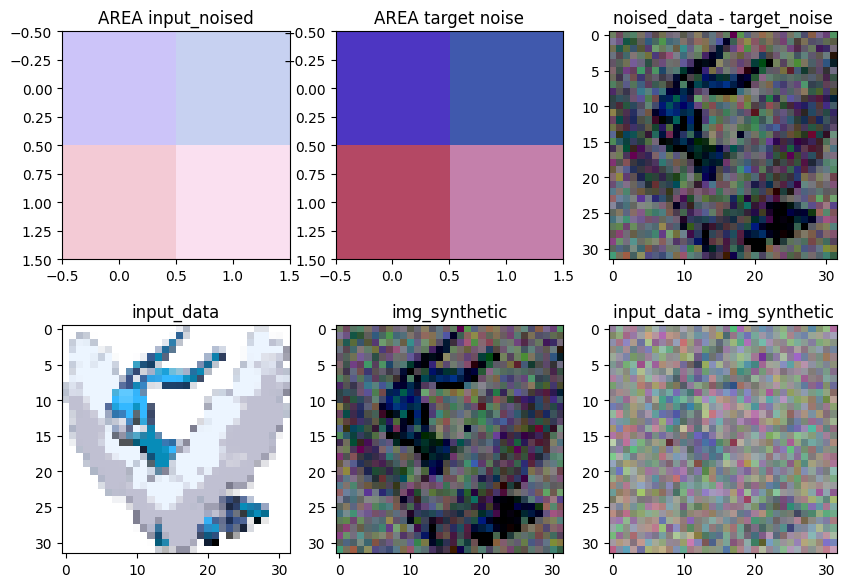

Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.02it/s]


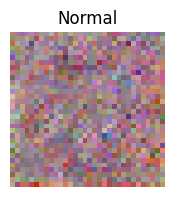

8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 0.1182  
Epoch 61/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.1082
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0637
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.4041
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.1255
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.1926
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.1059
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0555
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0635
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.1988
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0672
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.1249
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.1682
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.1487
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.1614
Epoch 75

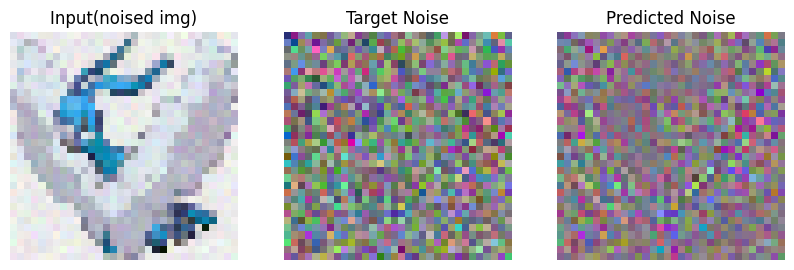

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.17451215, shape=(), dtype=float32)
MSE:  tf.Tensor(0.33613256, shape=(), dtype=float32)


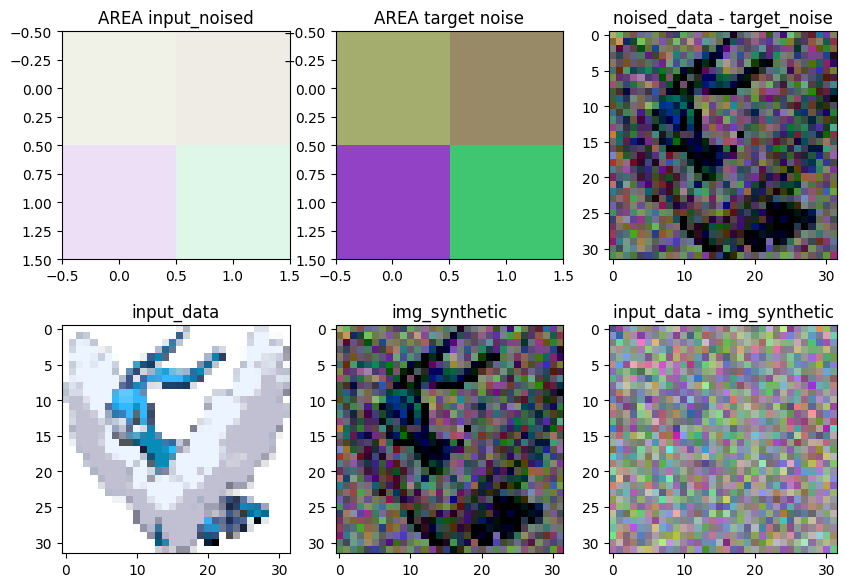

Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.18it/s]


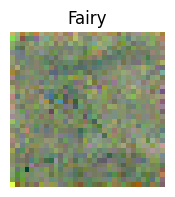

8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 0.1259  
Epoch 81/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0705
Epoch 82/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0886
Epoch 83/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0803
Epoch 84/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0823
Epoch 85/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0434
Epoch 86/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0926
Epoch 87/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0900
Epoch 88/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0757
Epoch 89/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0991
Epoch 90/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0734
Epoch 91/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0691
Epoch 92/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.1073
Epoch 93/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0599
Epoch 94/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1304
Epoch 95

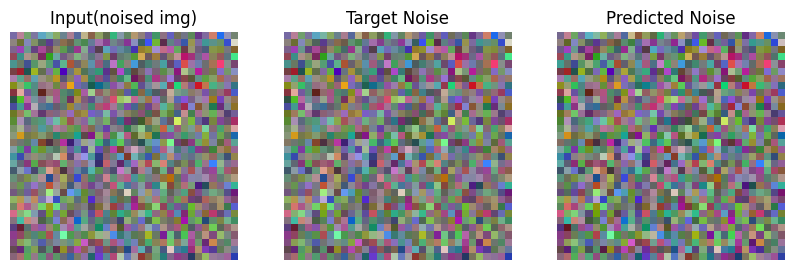

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00010980969, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7494121, shape=(), dtype=float32)


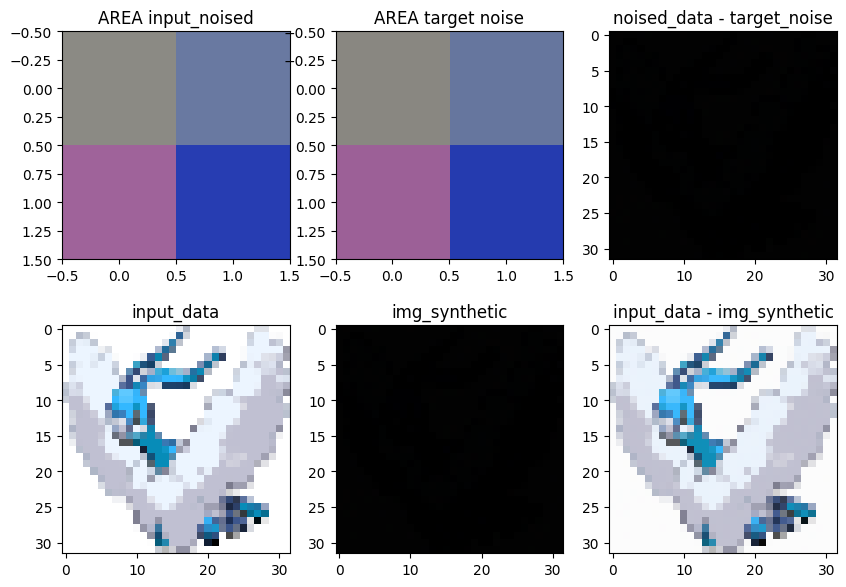

Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.76it/s]


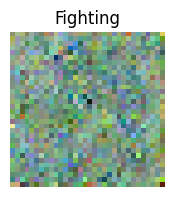

8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 0.0563  


In [9]:
tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[PlottingCallback(model, 20, IMG_SIZE), DiffusionCallback(model, 20)],
)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.75it/s]


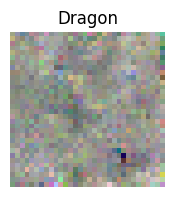

In [11]:
model.plot_samples(1, "Dragon")

Generating sample 1/4


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.39it/s]


Generating sample 2/4


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.43it/s]


Generating sample 3/4


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.50it/s]


Generating sample 4/4


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.38it/s]


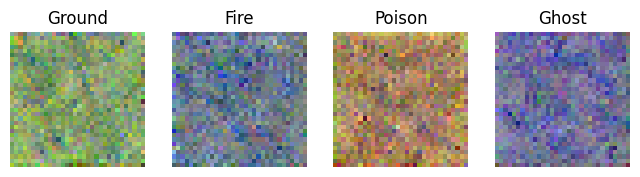

In [12]:
model.plot_samples(4)

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)